In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import time
from datetime import timedelta
import pandas as pd
from collections import OrderedDict
from transformers import AutoTokenizer
from sentencepiece import SentencePieceProcessor
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device_cap = torch.cuda.get_device_capability()
device_type = "cuda" if "cuda" in device else "cpu"
torch.cuda.set_device(device)
torch.manual_seed(8855)
print(torch.__version__)
print(device, device_cap)

2.1.0+cu121
cuda:0 (8, 6)


### Llama 2 from Scratch

In [2]:
# Using Huggingface
tokenizer = AutoTokenizer.from_pretrained("./llama2/")
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
# tokenizer.pad_token = tokenizer.eos_token #Optional

vocab = tokenizer.vocab

In [3]:
def encode(example):
    return tokenizer.encode(example, return_tensors="pt")


def decode(example):
    return tokenizer.batch_decode(
        example,
        skip_special_tokens=False,
        clean_up_tokenization_spaces=True,
    )[0]


print(f"Vocab Size: {len(vocab)}")
decode(
    encode(
        "hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"
    )
)

Vocab Size: 32001


'<s> hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions'

In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "hidden_dim": 768,
    "epochs": 1000,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}
GLOBAL_KEEP_TRACK = []

In [5]:
# Local Data only
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/TinyStoriesv1andv2-train.txt"],
        "val": ["../../data/TinyStoriesv1andv2-valid.txt"],
    },
    streaming=True,
)

# Stream Data
# dataset = load_dataset('IMJONEZZ/CombinedTinyStories') # optional: streaming=True but to_iterable is faster
# dataset = dataset.to_iterable_dataset()

# Minimal preprocessing
clean_dataset = dataset.filter(lambda example: len(example["text"]) > 2)

In [6]:
prompt = "Write a short story. Possible Story: "
tokenized_prompt = tokenizer(prompt, return_tensors="pt").input_ids

encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        [prompt + x for x in examples['text']],
        padding=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())

test = next(train_data)
print(f"Actual text: {test['text']}")
print(f"Input Ids: {tokenizer.decode(test['input_ids'])}")
print(f"Length of text: {len(test['input_ids'])}")
print(test)

Actual text: Tim looked under his bed and found a soft toy. He pushed the toy into the box. Next, he searched in his closet and found a ball. He pushed the ball into the box too. Tim was happy to see his box filling up.
Input Ids: <s> Write a short story. Possible Story: Tim looked under his bed and found a soft toy. He pushed the toy into the box. Next, he searched in his closet and found a ball. He pushed the ball into the box too. Tim was happy to see his box filling up.<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><P

### Needed functions

In [7]:
# @torch.compile #For non-Windows users
def get_batches(
    data,
    batch_size,
    context_window,
    config=MASTER_CONFIG,
    debug=False,
):
    x = []
    y = []
    for _ in range(batch_size): #Adjust this lower if you're running out of memory
        batch_data = next(data)

        # pick random starting points
        ix = torch.randint(
            0, len(batch_data["input_ids"]) - context_window - 1, (2,)
        )
        batch_x = torch.stack(
            [batch_data["input_ids"][i : i + context_window] for i in ix]
        ).long()
        batch_y = torch.stack(
            [
                batch_data["input_ids"][i + 1 : i + context_window + 1]
                for i in ix
            ]
        ).long()
        x.append(batch_x)
        y.append(batch_y)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    return x, y

def get_lora_batches(
    data,
    batch_size,
):
    x = []
    y = []
    for _ in range(batch_size):
        x_data = next(data)['input_ids'].long()
        y_data = next(data)['input_ids'].long()
        
        x.append(x_data)
        y.append(y_data)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    return x, y
        

In [52]:
@torch.no_grad()
def get_loss(model, lora=False, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for name, split in zip(["train", "val"], [train_data, val_data]):
        losses = []
        for _ in range(10):
            if lora==True:
                get_lora_batches(
                    split,
                    config['batch_size']
                )
            else:
                xb, yb = get_batches(
                    split,
                    config["batch_size"],
                    config["context_window"],
                )
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[name] = np.mean(losses)
    model.train()
    return out


@torch.inference_mode()
def generate(
    model,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=None,
    max_new_tokens=30,
):
    idx_list = [tokenized_prompt] * 5
    idx = torch.cat((idx_list),0).long().to(device)
    #idx = torch.ones(5, 1).long().to(device) #Alternative without prompt
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config["context_window"] :])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits

        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(
                last_time_step_logits,
                min(top_k, last_time_step_logits.size(-1)),
            )
            last_time_step_logits[
                last_time_step_logits < v[:, [-1]]
            ] = -float("Inf")
        p = F.softmax(
            last_time_step_logits, dim=-1
        )  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Gross neural network that doesn't work

In [9]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                #reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
# opt_model = torch.compile(model) #Again, non-Windows folks should be compiling functions and models
# xs, ys = get_batches(
#     train_data,
#     MASTER_CONFIG["batch_size"],
#     MASTER_CONFIG["context_window"],
# )

# logits, loss = model(xs, ys)

model params: 18547809


### Training Loop

In [51]:
def train(
    model,
    optimizer,
    scheduler=None,
    data=None,
    config=MASTER_CONFIG,
    lora=False,
    print_logs=False,
):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        try:
            optimizer.zero_grad()

            if lora:
                get_lora_batches(
                    data, config['batch_size']
                )
            else:
                xs, ys = get_batches(
                    data, config["batch_size"], config["context_window"]
                )
            
            logits, loss = model(xs, targets=ys)
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            if epoch % config["log_interval"] == 0:
                batch_time = time.time() - start_time
                x = get_loss(model, lora=lora)
                losses += [x]
                if print_logs:
                    print(
                        f"Epoch {epoch} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA: {timedelta(seconds=(batch_time * (config['epochs'] - epoch)/config['log_interval']))}"
                    )
                start_time = time.time()

                if scheduler:
                    print("lr: ", scheduler.get_last_lr())
        except StopIteration:
            print(f"Reached end of dataset on step {epoch}")
            break

    GLOBAL_KEEP_TRACK.append(
        f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']:.3f} | Val: {losses[-1]['val']:.3f}"
    )
    print(
        f"training loss {losses[-1]['train']:.3f} | validation loss: {losses[-1]['val']:.3f}"
    )
    return pd.DataFrame(losses).plot()

Epoch 0 | train loss 10.349 | val loss 10.343 | Time 0.119 | ETA: 0:00:02.387133
Epoch 50 | train loss 5.943 | val loss 5.878 | Time 0.345 | ETA: 0:00:06.562778
Epoch 100 | train loss 5.359 | val loss 5.425 | Time 0.338 | ETA: 0:00:06.079628
Epoch 150 | train loss 5.231 | val loss 5.254 | Time 0.340 | ETA: 0:00:05.779990
Epoch 200 | train loss 5.182 | val loss 4.894 | Time 0.341 | ETA: 0:00:05.450333
Epoch 250 | train loss 4.655 | val loss 4.743 | Time 0.341 | ETA: 0:00:05.120398
Epoch 300 | train loss 4.656 | val loss 4.464 | Time 0.408 | ETA: 0:00:05.708231
Epoch 350 | train loss 4.543 | val loss 4.443 | Time 0.399 | ETA: 0:00:05.190210
Epoch 400 | train loss 4.441 | val loss 4.255 | Time 0.400 | ETA: 0:00:04.801251
Epoch 450 | train loss 4.548 | val loss 4.287 | Time 0.407 | ETA: 0:00:04.475461
Epoch 500 | train loss 4.520 | val loss 4.506 | Time 0.399 | ETA: 0:00:03.992252
Epoch 550 | train loss 4.515 | val loss 4.374 | Time 0.398 | ETA: 0:00:03.578708
Epoch 600 | train loss 4.179 

<Axes: >

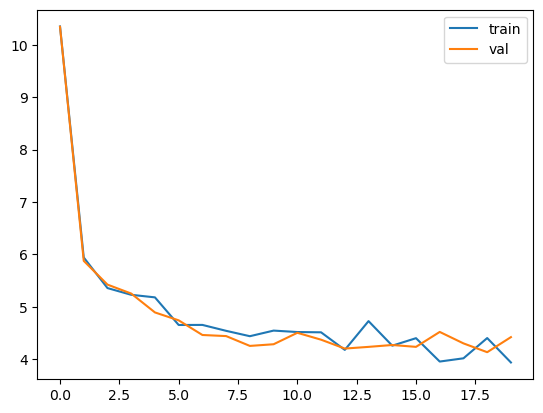

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, data=train_data, print_logs=True)

In [12]:
generate(model, config=MASTER_CONFIG)

["<s> Write a short story. Possible Story:  But together thisaroo name Lily said exciteded and smiled. She started to eating is '2 time, he did not quickly like to",
 '<s> Write a short story. Possible Story:  Lila outside her back in her to waved good as a short story. Today for his bath were before flew into one started to conhe her',
 '<s> Write a short story. Possible Story:  We want to take a walk to speed to cry. She found a smallts that he was a magic a lot and Sue liked Lily was really',
 "<s> Write a short story. Possible Story:  jog into the way home. Jack'll play in a sack. I want to exploreing in a book, and bought to hungry to",
 '<s> Write a short story. Possible Story: icy, you on. The ép said, it go home. Sam noddedled, theised saw a big?" Henry by her pocket!" Jack']

In [13]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 3.939 | Val: 4.423


### RMS Normalization

This is as opposed to the original Batch Normalization used in the original transformers paper.
Basically it works by taking 1/sqrt(N) * frobenius_norm

In [14]:
class RMSNormalization(nn.Module):
    def __init__(self, layer_shape, eps=1e-5, bias=False):
        super(RMSNormalization, self).__init__()
        self.eps = eps
        self.register_parameter(
            "scale", nn.Parameter(torch.ones(layer_shape))
        )

    def forward(self, x):
        """
        assumes shape (batch, seq_len, d_model)
        """
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[: x.shape[1], :].unsqueeze(0) * raw


test_batch = torch.randn((5, 11, 13))
m = RMSNormalization((11, 13))
g = m(test_batch)
print(g.shape)

torch.Size([5, 11, 13])


model params: 18557025
Epoch 0 | train loss 10.338 | val loss 10.327 | Time 0.021 | ETA: 0:00:00.421805
Epoch 50 | train loss 5.862 | val loss 5.753 | Time 0.413 | ETA: 0:00:07.845897
Epoch 100 | train loss 5.020 | val loss 5.376 | Time 0.412 | ETA: 0:00:07.407047
Epoch 150 | train loss 5.219 | val loss 4.911 | Time 0.424 | ETA: 0:00:07.200040
Epoch 200 | train loss 4.929 | val loss 4.918 | Time 0.419 | ETA: 0:00:06.696888
Epoch 250 | train loss 4.651 | val loss 4.631 | Time 0.406 | ETA: 0:00:06.089569
Epoch 300 | train loss 4.821 | val loss 4.623 | Time 0.354 | ETA: 0:00:04.958171
Epoch 350 | train loss 4.586 | val loss 4.305 | Time 0.352 | ETA: 0:00:04.576003
Epoch 400 | train loss 4.313 | val loss 4.449 | Time 0.353 | ETA: 0:00:04.236013
Epoch 450 | train loss 4.577 | val loss 4.454 | Time 0.353 | ETA: 0:00:03.882981
Epoch 500 | train loss 4.386 | val loss 4.662 | Time 0.356 | ETA: 0:00:03.559978
Epoch 550 | train loss 4.268 | val loss 4.489 | Time 0.408 | ETA: 0:00:03.672004
Epoch 

<Axes: >

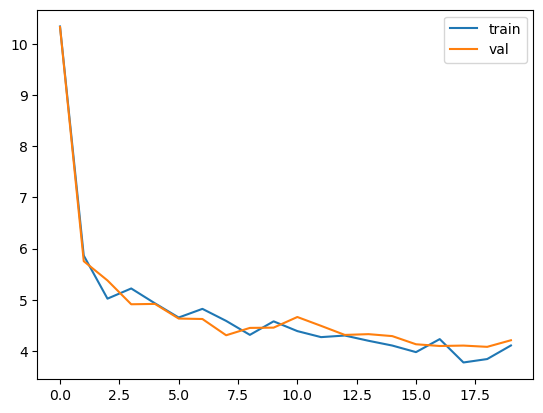

In [15]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)  # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                #reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [16]:
generate(model, config=MASTER_CONFIG)

['<s> Write a short story. Possible Story:  made herakes.  small beautiful all said, he was wrong for them of friends because she was clean the dinner. "Its ch. Possible',
 '<s> Write a short story. Possible Story:  boy went in a distant aunque day?" asked her t together on it that day on and faster. He saw a short story. He started toåk',
 '<s> Write a short story. Possible Story:  showed a girl was angry and felt bad. It could girl named Max the tree from the stones to play, a bush better. Possible Story:!',
 '<s> Write a short story. Possible Story: icy special special his to hop." After a nap, Max was even shirt asked. . Possible Story: <|> of a big tree',
 '<s> Write a short story. Possible Story: 3 everything. It was niceo about his d far away from around the proud of himself she said and needed he could know what said, and make']

In [17]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 3.939 | Val: 4.423
SimpleFeedForwardNN_RMS 18557025 Params | Train: 4.106 | Val: 4.207


### RoPE scaling

Rotary Embeddings changes the positional encoding from being based on sine and cosine to being based on the rotation of the embeddings, with a different rotation at each position

In [18]:
@jit(
    nopython=False
)  # Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros(
        (context_window, embedding_dim, embedding_dim), requires_grad=False
    )
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

C:\Users\chris\AppData\Local\Temp\ipykernel_4396\388148385.py:1: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(


C:\Users\chris\AppData\Local\Temp\ipykernel_4396\388148385.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_rotary_matrix" failed type inference due to: Unknown attribute 'zeros' of type Module(<module 'torch' from 'c:\\Users\\chris\\anaconda3\\envs\\llmbook\\Lib\\site-packages\\torch\\__init__.py'>)

File "..\..\..\..\AppData\Local\Temp\ipykernel_4396\388148385.py", line 5:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\chris\AppData\Local\Temp\ipykernel_4396\388148385.py (5)

File "..\..\..\..\AppData\Local\Temp\ipykernel_4396\388148385.py", line 5:
<source missing, REPL/exec in use?>

  @jit(
C:\Users\chris\AppData\Local\Temp\ipykernel_4396\388148385.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_rotary_matrix" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..

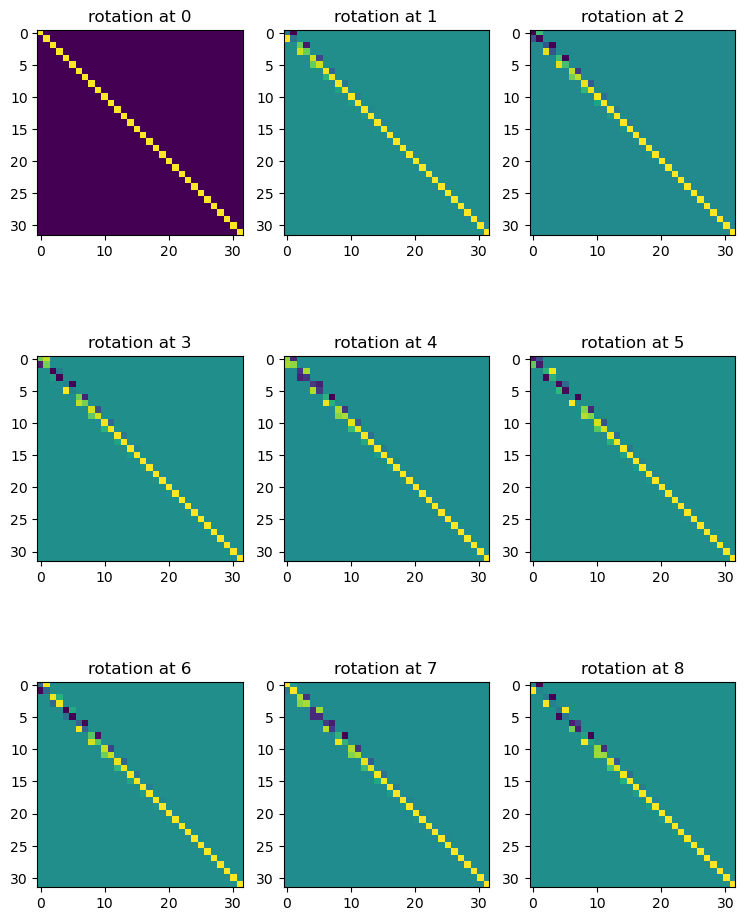

In [19]:
from IPython.display import clear_output

K = 3
config = {
    "batch_size": 10,
    "d_model": 32,
    "n_heads": 8,
    "context_window": K**2,
}
batch = torch.randn(1, config["context_window"], config["d_model"])
R = get_rotary_matrix(config["context_window"], config["d_model"])
# clear_output()
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f"rotation at {i * K + j}")

In [20]:
config = {
    "batch_size": 10,
    "d_model": 512,
    "n_heads": 8,
    "context_window": 16,
}


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_k = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_v = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )

        self.R = get_rotary_matrix(
            config["context_window"], config["d_model"]
        ).to(device)

    @jit(nopython=False)
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros(
            (context_window, embedding_dim, embedding_dim),
            requires_grad=False,
        )
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)

        q_rotated = (
            (torch.bmm(q.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )
        k_rotated = (
            (torch.bmm(k.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0).to(
                device
            )
            attn_weights = (
                torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
                + attn_mask
            )
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn(
    (config["batch_size"], config["context_window"], config["d_model"])
)
output, attn_weights = layer(batch, return_attn_weights=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_4396\2521293711.py:27: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False)


In [21]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList(
            [
                RoPEMaskedAttentionHead(config).to(device)
                for _ in range(config["n_heads"])
            ]
        )
        self.linear = nn.Linear(
            config["n_heads"] * config["d_model"], config["d_model"]
        ).to(device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.to(device)
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones(
    (
        MASTER_CONFIG["batch_size"],
        MASTER_CONFIG["context_window"],
        MASTER_CONFIG["d_model"],
    )
)
output = layer(batch)
output.shape

torch.Size([16, 32, 288])

model params: 20547969
Epoch 0 | train loss 10.421 | val loss 10.434 | Time 0.011 | ETA: 0:00:00.220017
Epoch 50 | train loss 5.943 | val loss 6.100 | Time 0.682 | ETA: 0:00:12.957999
Epoch 100 | train loss 5.061 | val loss 5.113 | Time 0.765 | ETA: 0:00:13.776705
Epoch 150 | train loss 4.645 | val loss 4.985 | Time 0.656 | ETA: 0:00:11.154690
Epoch 200 | train loss 4.526 | val loss 5.175 | Time 0.664 | ETA: 0:00:10.624008
Epoch 250 | train loss 4.248 | val loss 4.501 | Time 0.662 | ETA: 0:00:09.930031
Epoch 300 | train loss 4.055 | val loss 4.559 | Time 0.693 | ETA: 0:00:09.701994
Epoch 350 | train loss 4.126 | val loss 4.523 | Time 0.659 | ETA: 0:00:08.560651
Epoch 400 | train loss 4.575 | val loss 4.217 | Time 0.655 | ETA: 0:00:07.860000
Epoch 450 | train loss 4.184 | val loss 4.353 | Time 0.666 | ETA: 0:00:07.326022
Epoch 500 | train loss 4.209 | val loss 4.066 | Time 0.698 | ETA: 0:00:06.980004
Epoch 550 | train loss 3.904 | val loss 4.041 | Time 0.615 | ETA: 0:00:05.534998
Epoch 

<Axes: >

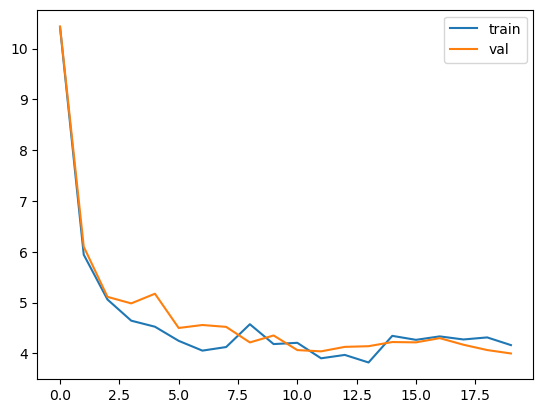

In [22]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)
        self.rope_attention = RoPEMaskedMultiheadAttention(config).to(
            device
        )

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]), nn.ReLU()
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                #reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [23]:
generate(model, config=MASTER_CONFIG)

['<s> Write a short story. Possible Story: ashed an old a middle of fun each cover when he picked very proud. They all looked it in theirool the teeth. David. And: inv',
 '<s> Write a short story. Possible Story: . It stepped down down then they when she snake you sure that anyone special." Tommy flew. And she looked up for himself and said,',
 '<s> Write a short story. Possible Story:  One morning and Sam. I want to play with the ordinary back and dog> fun passed boy in delight, "This is a bag, who was',
 '<s> Write a short story. Possible Story:  Susie because Leo haveily in to take things, old woman bored felt acom." Bob and Ben wanted to a await him toy.',
 "<s> Write a short story. Possible Story:  One mom perfed listen. When the rest of the doll. Tim thought he was so excited, and picks. Timmy laughed and let'"]

In [24]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 3.939 | Val: 4.423
SimpleFeedForwardNN_RMS 18557025 Params | Train: 4.106 | Val: 4.207
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 4.164 | Val: 3.999


### SwiGLU

Replace ReLU activation function. Defined as SwiGLU(x) = Swishβ(xW + b)⊗︀(xV + c)

In [25]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(
            self.beta * self.linear_gate(x)
        )
        out = swish_gate * self.linear(x)
        return out

model params: 20714434
Epoch 0 | train loss 10.431 | val loss 10.455 | Time 0.017 | ETA: 0:00:00.339985
Epoch 50 | train loss 5.435 | val loss 6.310 | Time 0.708 | ETA: 0:00:13.452031
Epoch 100 | train loss 5.060 | val loss 5.482 | Time 0.678 | ETA: 0:00:12.203995
Epoch 150 | train loss 5.024 | val loss 5.675 | Time 0.669 | ETA: 0:00:11.373011
Epoch 200 | train loss 4.834 | val loss 5.354 | Time 0.673 | ETA: 0:00:10.767998
Epoch 250 | train loss 4.519 | val loss 4.676 | Time 0.714 | ETA: 0:00:10.710000
Epoch 300 | train loss 4.515 | val loss 4.435 | Time 0.674 | ETA: 0:00:09.436017
Epoch 350 | train loss 4.068 | val loss 4.518 | Time 0.681 | ETA: 0:00:08.853003
Epoch 400 | train loss 4.315 | val loss 4.606 | Time 0.686 | ETA: 0:00:08.231996
Epoch 450 | train loss 4.459 | val loss 4.549 | Time 0.672 | ETA: 0:00:07.391999
Epoch 500 | train loss 4.120 | val loss nan | Time 0.672 | ETA: 0:00:06.719987
Epoch 550 | train loss 4.106 | val loss 4.192 | Time 0.687 | ETA: 0:00:06.183020
Epoch 60

<Axes: >

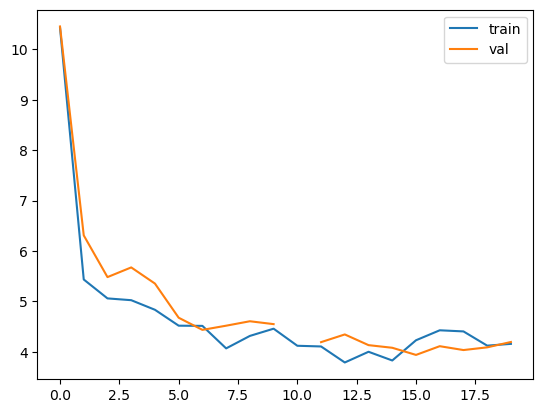

In [26]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        )
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                #reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [27]:
generate(model, config=MASTER_CONFIG)

['<s> Write a short story. Possible Story:  st She takes from the smiled and said, "Oh." Help. You have to have a kind boxes his family, mouth happily  She',
 '<s> Write a short story. Possible Story:  Do you each otherash with applesW little and you give process are friends. They they had a very brave and warm. They wish, but',
 '<s> Write a short story. Possible Story: 3 a type said, "."  She sp terrorunny. She incre longer is tight and aL habess saw theay. But we',
 '<s> Write a short story. Possible Story:  has old mind. He feels sticks and soup."l to play with the boats. As they near the mouse. They says, "Let\'',
 '<s> Write a short story. Possible Story: ite said they colorful Camera and chocolateay. She pulled. They hugged and said, " sky. Sheпис him before I']

In [28]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 3.939 | Val: 4.423
SimpleFeedForwardNN_RMS 18557025 Params | Train: 4.106 | Val: 4.207
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 4.164 | Val: 3.999
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 4.158 | Val: 4.195


In [29]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()
import gc

gc.collect()

6

### Llama

So what makes Llama 2 different from regular simple feed forward networks? Blocks of RMSNorm and Residual Rope Attention. Let's make those blocks and create our model

In [30]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config["hidden_dim"]),
            SwiGLU(config["hidden_dim"]),
            nn.Linear(config["hidden_dim"], config["d_model"]),
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [31]:
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]*2),
            SwiGLU(config["d_model"]*2),
            nn.Linear(config["d_model"]*2, config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                #reduction="sum",
            )
            return logits, loss

model params: 50260648
Epoch 0 | train loss 10.352 | val loss 10.349 | Time 0.186 | ETA: 0:00:03.713803
Epoch 50 | train loss 6.531 | val loss 6.685 | Time 2.489 | ETA: 0:00:47.291006
Epoch 100 | train loss 8.257 | val loss 10.641 | Time 2.543 | ETA: 0:00:45.774004
Epoch 150 | train loss 123.148 | val loss 177.573 | Time 2.518 | ETA: 0:00:42.805998
Epoch 200 | train loss 6.830 | val loss 7.282 | Time 2.520 | ETA: 0:00:40.320015
Epoch 250 | train loss 6.388 | val loss 6.741 | Time 2.534 | ETA: 0:00:38.009999
Epoch 300 | train loss 6.323 | val loss 6.603 | Time 2.547 | ETA: 0:00:35.658006
Epoch 350 | train loss 6.376 | val loss 6.575 | Time 2.521 | ETA: 0:00:32.773002
Epoch 400 | train loss 6.271 | val loss 6.401 | Time 2.540 | ETA: 0:00:30.481444
Epoch 450 | train loss 6.173 | val loss 6.354 | Time 2.563 | ETA: 0:00:28.192989
Epoch 500 | train loss 6.236 | val loss 6.321 | Time 2.538 | ETA: 0:00:25.379999
Epoch 550 | train loss 6.156 | val loss 6.300 | Time 2.570 | ETA: 0:00:23.130186
E

<Axes: >

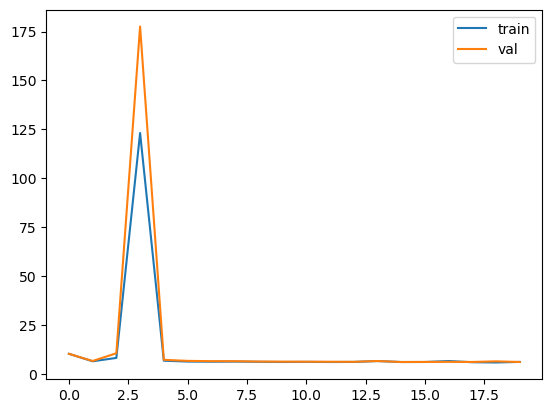

In [32]:
MASTER_CONFIG["epochs"] = 1000

llama = SimpleLlama(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(llama.parameters())
train(
    llama, optimizer, data=train_data, config=MASTER_CONFIG, print_logs=True
)

In [61]:
generate(llama, config=MASTER_CONFIG, temperature=1.0, top_k=25, max_new_tokens=50)

['<s> Write a short story. Possible Story: ." that. he of." of and. her. you she.! was he he and they the the to the the.". the with., that and\'. happy He,."... not and He a,. to,',
 '<s> Write a short story. Possible Story:  the! the her happy.. in in the,, the was,." to.,. a a it to they. with in have the. a,, and the He. a her.. a and.. with said was and',
 '<s> Write a short story. Possible Story: . the her. of to and.\' it,, to."ed be he she and.. the .".  they a a it, to. said.. and is in and that..... the,. it',
 "<s> Write a short story. Possible Story:  with the . her Sheed that she not a.. to a' a the she and a in and. a to he in and. to. for was. the.. it. happy said., in her of a in and",
 '<s> Write a short story. Possible Story:  it., the\'.. he and." and of and. to said. to. to,. to it a and She... her.. They is.. the He and a to and to she the.,. with']

In [34]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 3.939 | Val: 4.423
SimpleFeedForwardNN_RMS 18557025 Params | Train: 4.106 | Val: 4.207
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 4.164 | Val: 3.999
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 4.158 | Val: 4.195
SimpleLlama 50260648 Params | Train: 6.224 | Val: 6.166


In [35]:
MASTER_CONFIG["epochs"] = 1000
MASTER_CONFIG["batch_size"] = 16
MASTER_CONFIG["d_model"] = 768
MASTER_CONFIG["n_layers"] = 8
MASTER_CONFIG['context_window'] = 64

llama = SimpleLlama(MASTER_CONFIG).to(device)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=1e-1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)
train_data = iter(encoded_dataset["train"].shuffle())

model params: 212209674


Epoch 0 | train loss 10.343 | val loss 10.337 | Time 0.678 | ETA: 0:00:13.557453
lr:  [0.0004999987909744553]
Epoch 50 | train loss 10.276 | val loss 10.392 | Time 14.329 | ETA: 0:04:32.248151
lr:  [0.0004968620434287298]
Epoch 100 | train loss 10.161 | val loss 10.123 | Time 14.389 | ETA: 0:04:19.003956
lr:  [0.00048776984967968684]
Epoch 150 | train loss 6.592 | val loss 6.663 | Time 14.426 | ETA: 0:04:05.245155
lr:  [0.0004729460897126908]
Epoch 200 | train loss 6.451 | val loss 6.427 | Time 14.454 | ETA: 0:03:51.257084
lr:  [0.0004527557736953662]
Epoch 250 | train loss 6.198 | val loss 6.318 | Time 14.506 | ETA: 0:03:37.593005
lr:  [0.0004276960542158767]
Epoch 300 | train loss 6.344 | val loss 6.695 | Time 14.542 | ETA: 0:03:23.590661
lr:  [0.00039838398473624826]
Epoch 350 | train loss 6.222 | val loss 6.250 | Time 14.518 | ETA: 0:03:08.732911
lr:  [0.00036554132568825045]
Epoch 400 | train loss 6.266 | val loss 6.247 | Time 14.534 | ETA: 0:02:54.407464
lr:  [0.00032997677233618

<Axes: >

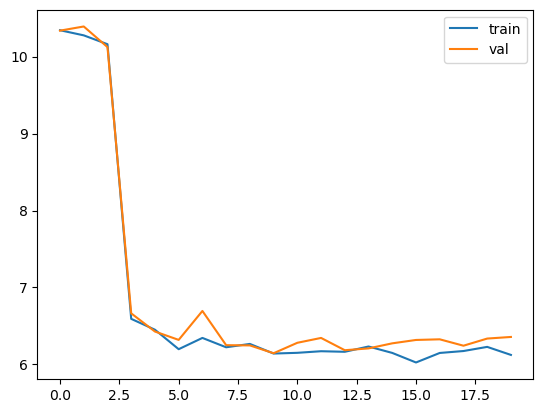

In [36]:
train(
    llama,
    llama_optimizer,
    scheduler=scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    print_logs=True,
)

In [65]:
generate(llama, config=MASTER_CONFIG, temperature=1.0, top_k=100, max_new_tokens=50)

['<s> Write a short story. Possible Story:  to could felt was you mom!" to " to. and and for for to a. it was " was! that " happy noty L him in. to. to. on her. it he and sad.. amy it!",',
 '<s> Write a short story. Possible Story: . to You M They I She play But She.. you to they the the for he in?", happy he in it his. his we too was together on her are is of but mom and, L day,ared a a. "',
 '<s> Write a short story. Possible Story: ." my.. it the. the is  what the I and and was mom was you the But have she. a and the at to me will and it a that wanted." too her is.  it.! and you with',
 '<s> Write a short story. Possible Story:  for so her." Itly a.,.. he the.ug the in was from happy. with Tim up She her.\' to She can fun.!" not...ly felt  mom youily L a. of..',
 "<s> Write a short story. Possible Story: ed sad' She of said he. and with But had They the with hised She happy the' back their together!  and,. and for. fun. to how he with wasy he it. himug. was. Ben a"]

In [38]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 3.939 | Val: 4.423
SimpleFeedForwardNN_RMS 18557025 Params | Train: 4.106 | Val: 4.207
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 4.164 | Val: 3.999
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 4.158 | Val: 4.195
SimpleLlama 50260648 Params | Train: 6.224 | Val: 6.166
SimpleLlama 212209674 Params | Train: 6.123 | Val: 6.357


In [39]:
# LLAMA_CONFIG = {
#     "vocab_size": 32000,
#     "batch_size": 2,
#     "context_window": 256,
#     "d_model": 768,
#     "hidden_dim": 1536,
#     "epochs": 1,
#     "log_interval": 1,
#     "n_heads": 8,
#     "n_layers": 8,
# }

# # Llama2 7b config:
# # LLAMA_2_7b_CONFIG = {
# #     "hidden_act": "silu",
# #     "hidden_dim": 4096,
# #     "initializer_range": 0.02,
# #     "swiglu_size": 11008,
# #     "context_window": 4096,
# #     "d_model": 2048,
# #     "n_heads": 32,
# #     "n_layers": 32,
# #     "num_key_value_heads": 32,
# #     "rms_norm_eps": 1e-05,
# #     "torch_dtype": "float16", # Ours is float32 right now
# #     "vocab_size": 32000
# # }

# # # Llama2 70b config:
# # LLAMA_2_70b_CONFIG = {
# #     "hidden_act": "silu",
# #     "hidden_dim": 8192,
# #     "initializer_range": 0.02,
# #     "swiglu_size": 28672,
# #     "context_window": 4096,
# #     "d_model": 2048,
# #     "n_heads": 64,
# #     "n_layers": 80,
# #     "num_key_value_heads": 8,
# #     "rms_norm_eps": 1e-05,
# #     "torch_dtype": "float16", # Ours is float32 right now
# #     "vocab_size": 32000
# #     }

In [40]:
# Training with epochs instead of steps
# def train(
#     model, optimizer, dataset, scheduler=None, config=LLAMA_CONFIG, print_logs=False
# ):
#     losses = []

#     start_time = time.time()
#     for epoch in range(config["epochs"]):
#         for step, example in enumerate(dataset):
#             try:
#             optimizer.zero_grad()

#             xs, ys = _get_batch(example, 2, config['context_window'])
#             _, loss = model(xs, targets=ys)
#             loss.backward()
#             optimizer.step()

#             if scheduler:
#                 scheduler.step()

#             if i % config["log_interval"] == 0:
#                 batch_time = time.time() - start_time
#                 x = get_loss(model)
#                 losses += [x]
#                 if print_logs:
#                     print(
#                         f"Epoch {epoch} | Step {i} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - i) :.3f}"
#                     )
#                 start_time = time.time()

#                 if scheduler:
#                     print("lr: ", scheduler.get_last_lr())
#               except StopIteration:
#                   print(f"Finished dataset at step {step}")
#                   break
#     print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
#     GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
#     return pd.DataFrame(losses).plot()

In [41]:
# llama = Llama(LLAMA_CONFIG).to(device)

# llama_optimizer = torch.optim.Adam(
#     llama.parameters(),
#     betas=(0.9, 0.95),
#     weight_decay=0.1,
#     eps=1e-9,
#     lr=1e-3,
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     llama_optimizer, 1000, eta_min=1e-5
# )

# Quantization

In [42]:
llama.to("cpu")
qconfig_dict = {
    torch.nn.Embedding: torch.quantization.float_qparams_weight_only_qconfig,
    torch.nn.Linear: torch.quantization.default_dynamic_qconfig,
}
# Post Training Dynamic Quantization
dynamic_quantized_llama = torch.quantization.quantize_dynamic(
    llama, qconfig_dict, dtype=torch.qint8
)


# Get Size difference
def get_param_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size


def get_buffer_size(model):
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return buffer_size


def get_param_and_buffer_size(model):
    param_size = get_param_size(model)
    buffer_size = get_buffer_size(model)
    return param_size, buffer_size


def get_size_difference(models: list) -> str:
    keeping_track = []
    for idx, model in enumerate(models):
        param_size, buffer_size = get_param_and_buffer_size(model)
        size_all_mb = (param_size + buffer_size) / 1024**2
        keeping_track.append(
            f"{type(model).__name__} size: {size_all_mb:.3f}MB"
        )
    return keeping_track


list_of_sizes = get_size_difference([llama, dynamic_quantized_llama])
for size in list_of_sizes:
    print(size)

SimpleLlama size: 809.516MB
SimpleLlama size: 1.500MB


# LoRA

If you have this:

<p>def forward(self, x):<br>
    x = self.linear_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x)<br>
    return x<br></p>

change it to this:

<p>def forward(self, x):<br>
    x = self.linear_1(x) + self.lora_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x) + self.lora_2(x)<br>
    return logits<br></p>

In [43]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        standard_deviation = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(
            torch.randn(in_dim, rank) * standard_deviation
        )
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x


class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [44]:
from functools import partial


# Utils
class LoRAParametrization(nn.Module):
    def __init__(
        self,
        fan_in,
        fan_out,
        fan_in_fan_out=False,
        rank=0,
        lora_dropout_p=0.0,
        lora_alpha=1,
    ):
        super().__init__()
        self.swap = (
            (lambda x: (x[1], x[0])) if fan_in_fan_out else (lambda x: x)
        )
        self.lora_A = nn.Parameter(torch.zeros(self.swap((rank, fan_in))))
        self.lora_B = nn.Parameter(torch.zeros(self.swap((fan_out, rank))))
        self.lora_alpha, self.rank = lora_alpha, rank
        self.scaling = lora_alpha / rank
        self.lora_dropout = (
            nn.Dropout(p=lora_dropout_p)
            if lora_dropout_p > 0
            else lambda x: x
        )
        self.dropout_fn = (
            self._dropout if lora_dropout_p > 0 else lambda x: x
        )
        self.register_buffer(
            "lora_dropout_mask",
            torch.ones(self.swap((1, fan_in)), dtype=self.lora_A.dtype),
        )
        self.forward_fn = self.lora_forward

    def forward(self, X):
        return self.forward_fn(X)

    def lora_forward(self, X):
        return (
            X
            + torch.matmul(
                *self.swap((self.lora_B, self.dropout_fn(self.lora_A)))
            ).view(X.shape)
            * self.scaling
        )

    @classmethod
    def lora_from_layer(
        cls, layer, rank=0, lora_dropout_p=0.0, lora_alpha=1
    ):
        fan_out, fan_in = layer.weight.shape
        return cls(
            fan_in,
            fan_out,
            fan_in_fan_out=False,
            rank=rank,
            lora_dropout_p=lora_dropout_p,
            lora_alpha=lora_alpha,
        )


lora_config = {
    nn.Linear: {
        "weight": partial(LoRAParametrization.lora_from_layer, rank=16),
    },
}


def apply_lora(layer, register=True, merge=False, lora_config=lora_config):
    if register:
        if type(layer) in lora_config:
            for attr_name, parametrization in lora_config[
                type(layer)
            ].items():
                torch.nn.utils.parametrize.register_parametrization(
                    layer, attr_name, parametrization(layer)
                )
    else:
        if hasattr(layer, "parametrizations"):
            for attr_name in layer.parametrizations.keys():
                torch.nn.utils.parametrize.remove_parametrizations(
                    layer, attr_name, leave_parametrized=merge
                )


def add_lora(model, lora_config=lora_config):
    model.apply(partial(apply_lora, lora_config=lora_config))


def merge_lora(model):
    model.apply(partial(apply_lora, register=False, merge=True))


def name_is_lora(name):
    return (
        len(name.split(".")) >= 4
        and (name.split(".")[-4]) == "parametrizations"
        and name.split(".")[-1] in ["lora_A", "lora_B"]
    )


def get_params_by_name(model, print_shapes=False, name_filter=None):
    for n, p in model.named_parameters():
        if name_filter is None or name_filter(n):
            if print_shapes:
                print(n, p.shape)
            yield p


def get_lora_params(model, print_shapes=False):
    return get_params_by_name(
        model, print_shapes=print_shapes, name_filter=name_is_lora
    )

In [45]:
# Show how the blocks change, but we'll use our already-trained model
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            LinearWithLoRA(config["d_model"], config["d_model"]),  # NEW
            SwiGLU(config["d_model"]),
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x


class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            LinearWithLoRA(config["d_model"], config["d_model"]),  # NEW
            SwiGLU(config["d_model"]),
            LinearWithLoRA(config["d_model"], config["vocab_size"]),  # NEW
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                #reduction="sum",
            )
            return logits, loss

In [46]:
# New Dataset for Lora
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/Lima-train.csv"],
        "val": ["../../data/Lima-test.csv"],
    },
    streaming=True,
)

encoded_dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        padding="max_length",
        max_length=256,
        truncation=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"])
val_data = iter(encoded_dataset["val"])
print(next(train_data))
print(next(train_data))

{'text': '"[\'Can brain cells move? By movement I mean long distance migration (preferably within the brain only).\'', 'input_ids': tensor([    1,   376,  1839,  6028, 17294,  9101,  4337, 29973,  2648, 10298,
          306,  2099,  1472,  5418, 20332,   313,  1457,   571,  2197,  2629,
          278, 17294,   871,   467, 29915, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32

In [47]:
# Step 1: Add LoRA to trained model
llama.to("cpu")
add_lora(llama)
llama.to(device)

# Step 2: Get the LoRA params instead of the whole model's
parameters = [{"params": list(get_lora_params(llama))}]
# Step 3: initialize optimizer with LoRA Params
lora_optimizer = torch.optim.AdamW(parameters, lr=1e-3)

In [66]:
# Step 4: Train
for _ in range(3):
    train_data = iter(encoded_dataset["train"])
    val_data = iter(encoded_dataset["val"])
    train(
        llama,
        lora_optimizer,
        scheduler,
        data=train_data,
        config=MASTER_CONFIG,
        lora=True,
        print_logs=True,
    )

# Step 5: export the params
state_dict = llama.state_dict()
lora_state_dict = {k: v for k, v in state_dict.items() if name_is_lora(k)}

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
# Loading and Inferencing with LoRA
add_lora(llama)

_ = llama.load_state_dict(lora_state_dict, strict=False)

merge_lora(llama)

generate(llama)